# Python Learn by Doing: ENSO Analysis

Developed By: Dr. Kerrie Geil, Mississippi State University

Date: April 2024

Requirements: list space, RAM, and pacakge requirements

Link: notebook available to download at 

<u> Description </u>

This notebook helps the learner build intermediate python programming skills through data query, manipulation, analysis, and visualization. Learning will be centered around the El Nino Southern Oscillation (ENSO) climate pattern and its effects on temperature and precipitation. The notebook is aimed at learners who already have some knowledge of programming and statistics. 

<u> Summary of Contents </u>

put an outline of tasks/skills here

-----

# Introduction to ENSO

Put a description of what they are

Include a bunch of links
different ENSO indices https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni




# Science Questions

To pick up some useful intermediate python programming skills, this notebook will investigate the following ENSO-related science questions using simple statistics:

1) How many seasons (boreal DJF,MAM,JJA,SON) since xxxx have had strong El Nino and La Nina conditions?
2) Using composite analysis, what pattern do we see in sea surface temperature during El Nino and La Nina?
3) In which season(s) does El Nino have the strongest impacts on global temperature and precipitation?
4) Which areas of the United States experience statistically significant ENSO impacts on temperature and precipitation?
5) On average, is it El Nino or La Nina that has stronger effects on temperature and precipitation in the US?

**Disclaimer:** This notebook is intended for python programming learning. There are many datasets and statistical methods we could use to answer our science questions. The techniques used in this notebook are chosen for their simplicity since we are focused on learning intermediate programming skills as opposed to a focus on producing peer-review level analyses. You will undoubtedly see different techniques, thresholds, seasons, and more complex statisical methods used in ENSO literature. 


data description | frequency | units | dataset name | source
---|---|---|---|---
nino 3.4 sst index | monthly | C | Nino 3.4 SST index | [NOAA PSL](https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino34/)
sea surface temperature | monthly | C | HadISST1 | [UKMO Hadley Centre](https://www.metoffice.gov.uk/hadobs/hadisst/)
average air temperature | monthly | C | BEST | [Berkeley Earth](https://berkeleyearth.org/data/)
precipitation | monthly | mm/day | NOAA PREC/L | [NOAA PSL](https://psl.noaa.gov/data/gridded/data.precl.html)


# Importing Python Packages and Defining Your Workspace


In [1]:
# importing all the python packages we will need here

import os
# from urllib.request import urlretrieve
import xarray as xr
import numpy as np
import pandas as pd

# import numpy.testing as npt
# import warnings

import matplotlib.pyplot as plt
# from collections import OrderedDict
# import gzip
# import shutil

# import pandas as pd

In [2]:
# learners need to update these paths to reflect locations on their own computer/workspace

# path to your working directory (where this notebook is on your computer)
work_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/MSU_py_training/learn_by_doing/ENSO/' 
# work_dir = r'C://Users/kerrie.WIN/Documents/code/MSU_py_training/learn_by_doing/ENSO/' 

# path to where you'll download and store the data files
data_dir = r'C://Users/kerrie/Documents/02_LocalData/tutorials/ENSO/'
# data_dir=r'C://Users/kerrie.WIN/Documents/code/MSU_py_training/learn_by_doing/ENSO/'

# path to write output files and figures
output_dir = work_dir+'outputs/'

# create directories if they don't exist already
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Obtaining the Data

Scripted downloads of the datasets used here can be found in a separate notebook called [get_enso_datasets.ipynb](). If you haven't obtained the data already, use the get_enso_datasets notebook to download the Nino3.4 index, HadISST1 sea surface temperature, Berkeley Earth temperature, and GPCC precipitation data.

# Data Pre-processing

Set our 4 different datasets up with the same time dimension labels and calculate anomalies for SST, PR, and T using the same base period as the nino 3.4 index (1981-2010).


In [3]:
# filenames
nino_f = data_dir+'nino34_anomalies_monthly_NOAA.txt'
# sst_f = data_dir+'sst_monthly_HadISST1_UKMO.nc'
sst_f = data_dir+'sst_monthly_COBE2_JMA.nc'
t_f = data_dir+'tavg_monthly_BerkeleyEarth.nc'

pr_f = data_dir+'precip_monthly_PRECL_NOAA.nc'

# subset years
year_start = '1948'
year_end = '2023'

# base period years (for anomalies)
base_start = '1981'
base_end = '2010'

### Nino 3.4 Index

In [53]:
# load nino3.4 index data

# our data file contains a row for each year of data and each column is one of 12 monthly anomaly values for the Nino 3.4 area 
# the base period for the anomalies is 1981-2010

# there are plenty of ways to load txt data, we'll use pandas
nino_raw=pd.read_csv(nino_f,sep='\s+',skiprows=1,skipfooter=7,header=None,index_col=0,na_values=-99.99,engine='python')
# nino_raw

In [54]:
# collapse the data into a 1D array timeseries
nino=nino_raw.to_numpy().flatten()

# len(nino),nino

In [55]:
# create datetimes
dates=pd.date_range('1870-01-01','2024-12-01',freq='MS')

# len(dates),dates[0:3]

In [56]:
# create an xarray object with metadata labels attached (time)
nino=xr.DataArray(nino,dims='time',coords={'time':dates})

# assign some variable attributes
nino.attrs['standard_name']='nino3.4 index'
nino.attrs['units']='C'
# nino

In [57]:
# subset in time using time labels
nino=nino.sel(time=slice(year_start,year_end))
# nino

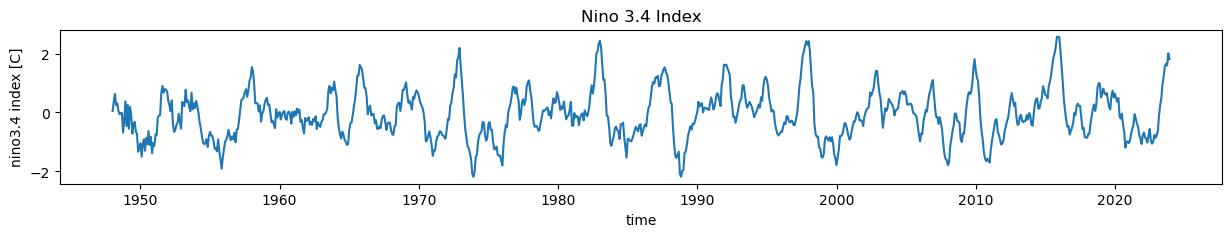

In [58]:
# plot it
fig=plt.figure(figsize=(15,2))
nino.plot()
plt.title("Nino 3.4 Index")
plt.show()

### Sea Surface Temperature

In [59]:
# get data
ds=xr.open_dataset(sst_f)
# ds

In [60]:
# pull variable from xr dataset
sst=ds.sst
# sst

In [62]:
# subset in time

# first assign new time values that will match nino (month start not center of months)
# dates=pd.date_range('1870-01-01','2024-02-01',freq='MS')
# sst['time']=dates

# now subset in time
sst=sst.sel(time=slice(year_start,year_end))
# sst

In [63]:
# calculate anomalies

# first calculate the monthly climatological values over the base period
sst_base=sst.sel(time=slice(base_start,base_end))
sst_clim=sst_base.groupby(sst_base.time.dt.month).mean('time')
# sst_clim

In [64]:
# now calculate the anomalies
sst_anom=sst.groupby(sst.time.dt.month) - sst_clim

# assign some variable attributes
sst_anom.attrs['standard_name']='sst anomaly'
sst_anom.attrs['units']='C'
# sst_anom

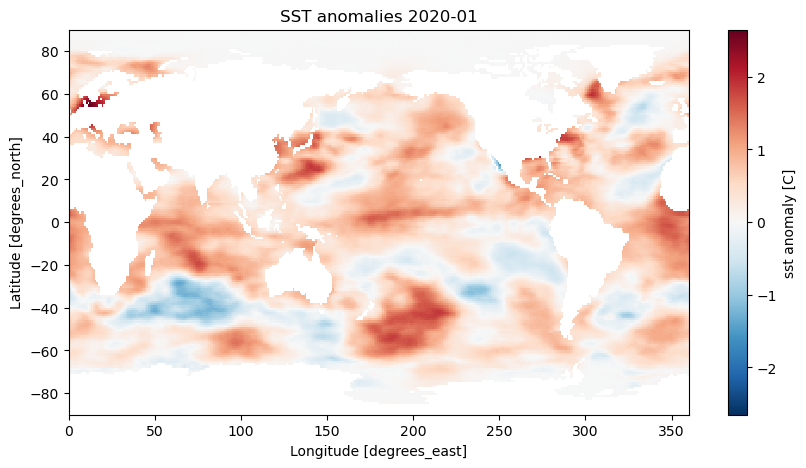

In [65]:
# plot it
ptime='2020-01'
fig=plt.figure(figsize=(10,5))
sst_anom.sel(time=ptime).plot()
plt.title('SST anomalies '+ptime)
plt.show()

### Precipitation

In [66]:
ds=xr.open_dataset(pr_f)
# ds

In [67]:
# pull variable from xr dataset
pr=ds.precip

# this data's times already match nino's so we don't need to re-assign the coordinate labels
# just subset
pr=pr.sel(time=slice(year_start,year_end))

# calculate anomalies
pr_base=pr.sel(time=slice(base_start,base_end))
pr_clim=pr_base.groupby(pr_base.time.dt.month).mean('time')
pr_anom=pr.groupby(pr.time.dt.month) - pr_clim

# assign some variables attributes
pr_anom.attrs['standard_name']='pr anomaly'
pr_anom.attrs['units']='mm/day'

# pr_anom

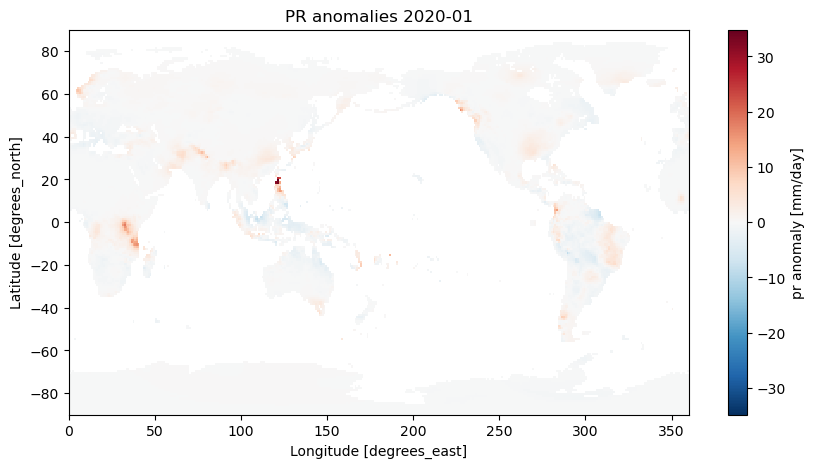

In [68]:
# plot it
fig=plt.figure(figsize=(10,5))
pr_anom.sel(time=ptime).plot()
plt.title('PR anomalies '+ptime)
plt.show()

### Temperature

In [69]:
ds=xr.open_dataset(t_f)
# ds

In [70]:
# these dates are whacky so we'll replace with datetimes to match the other datasets
dates=pd.date_range('1750-01-01','2024-03-01',freq='MS')
ds['time']=dates

# we also need to rename the dimension 'month_number' for groupby to work correctly
ds=ds.rename({'month_number':'month'})
# ds

In [72]:
# change base period
# this data is provided as anomalies using the base period 1951-1980
# we need to change the base period to match the rest of our data anomalies

# pull variables from xr dataset
t_anom_5180=ds.temperature
clim_5180=ds.climatology

# create temperature values working backward with anomalies plus climatology
t=t_anom_5180.groupby(t_anom_5180.time.dt.month)+clim_5180

# new base period climatological values
t_base=t.sel(time=slice(base_start,base_end))
clim_8110 = t_base.groupby(t_base.time.dt.month).mean('time')

# anomalies with new base period
t_anom=t.groupby(t.time.dt.month)-clim_8110

# subset in time
t_anom=t_anom.sel(time=slice(year_start,year_end))

# assign some variable attributes
t_anom.attrs['standard_name']='T anomaly'
t_anom.attrs['units']='C'

# t_anom

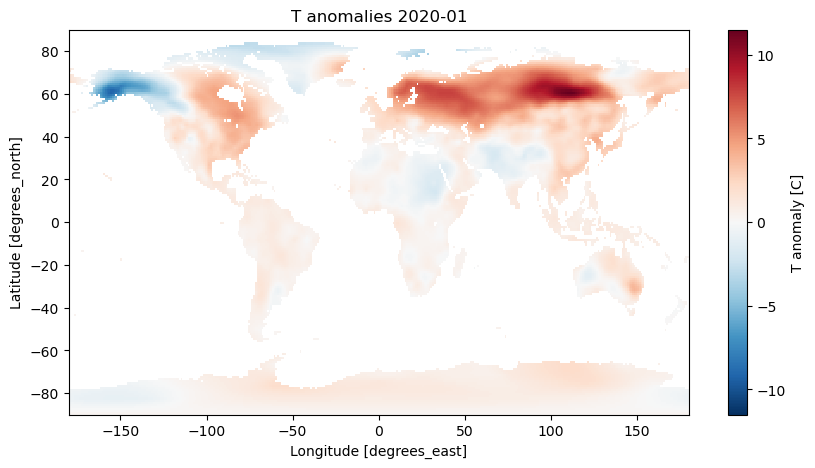

In [73]:
# plot it
ptime='2020-01'
fig=plt.figure(figsize=(10,5))
t_anom.sel(time=ptime).plot()
plt.title('T anomalies '+ptime)
plt.show()

We're now ready to start our analysis with the variables nino, sst_anom, pr_anom, and t_anom. If you are used to seeing a list of variables you've made (like in Matlab or RStudio) that is available for python/Jupyter through the IDE you use (like VS Code, Spyder, Pycharm, etc). There is usually a console option that you can open to see all the variables you've made is point. This is useful for seeing variable shapes and data types as well as seeing which variables you could potentially delete if you suspect you'll be memory limited during your analysis.

Let's double check our 4 variable shapes below: 

In [74]:
nino.shape, sst_anom.shape, pr_anom.shape, t_anom.shape

((912,), (912, 180, 360), (912, 180, 360), (912, 180, 360))

In [75]:
del ds,nino_raw,pr,pr_base,pr_clim,sst,sst_base,sst_clim,t,t_anom_5180,t_base

# 1) How many strong El Nino and La Nina events have occurred from 1948 to 2023?

The answer to this question of course depends on the definition of a strong ENSO event.

There are multiple methods for identifying ENSO and strong ENSO events but we will use the following criteria:
- Input data: Nino 3.4 Index 5-month centered running mean
- Criteria: 5 consecutive months exceeding the threshold value
- Threshold: +/- 0.7 C

In [155]:
# constants based on our criteria
nmonths=5
event_thresh=0.7
neutral_thresh=0.2

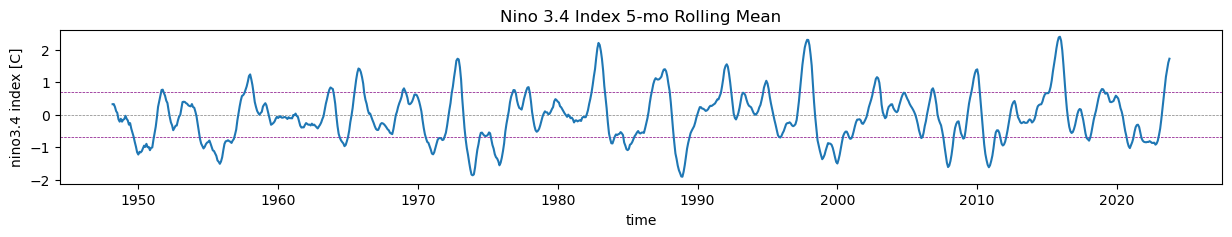

In [156]:
# first calculate the rolling mean
nino_rollmean=nino.rolling(time=nmonths,center=True).mean()

# plot it
fig=plt.figure(figsize=(15,2))
plt.axhline(y=-event_thresh,color='purple',linestyle='dashed',linewidth=0.5)
plt.axhline(y=0,color='grey',linestyle='dashed',linewidth=0.5)
plt.axhline(y=event_thresh,color='purple',linestyle='dashed',linewidth=0.5)
nino_rollmean.plot()
plt.title("Nino 3.4 Index 5-mo Rolling Mean")
plt.show()

Anywhere the nino3.4 rolling mean (blue line) exceeds the thresholds (purple lines) is potentially an ENSO event. To identify which peaks and valleys in the timeseries qualify as ENSO events we need to identify where the thresholds are exceeded for at least 5 consecutive months.  

We'll use a for loop to identify ENSO events in the timeseries and mark months during an El Nino event with +1 and months during a La Nina event with -1. 

We'll also use the criteria of 5 consecutive months under a threshold of 0.3C to identify neutral conditions and mark these months with 0.

In [157]:
# create an array to hold our results and initialize to 0
# create an array to hold our results and initialize to nan
nino_events=nino_rollmean.copy()
# nino_events[:]=0
nino_events[:]=np.nan
nino_events[0:4]

<xarray.DataArray (time: 4)> Size: 32B
array([nan, nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 32B 1948-01-01 1948-02-01 ... 1948-04-01
Attributes:
    standard_name:  nino3.4 index
    units:          C

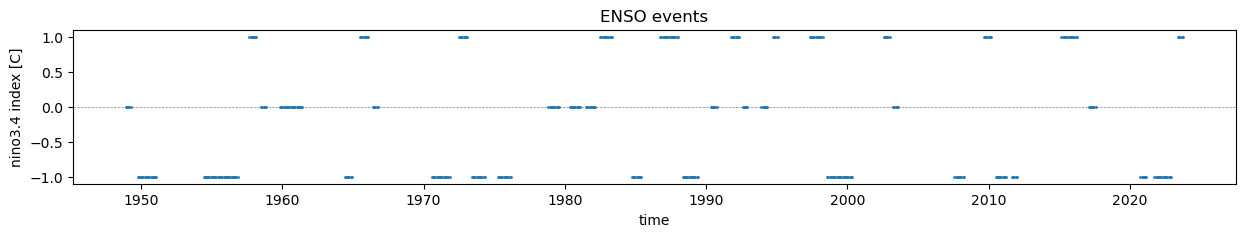

In [158]:
# loop through months and fill +1, -1, or 0 for windows of 5 months that meet our criteria

for i,value in enumerate(nino_rollmean):
    # neutral conditions    
    if (-neutral_thresh < value < neutral_thresh):
        # possible neutral conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(-neutral_thresh < window) & all(window < neutral_thresh):
            nino_events[i:i+nmonths]=0    

    # La Nina conditions
    if  value < -event_thresh:
        # possible La Nina conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window < -event_thresh):
            nino_events[i:i+nmonths]=-1

    # El Nino conditions
    if  value > event_thresh:
        # possible El Nino conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window > event_thresh):
            nino_events[i:i+nmonths]=1     


            
# plot it
fig=plt.figure(figsize=(15,2))
plt.axhline(y=0,color='grey',linestyle='dashed',linewidth=0.5)
nino_events.plot(linestyle='None',marker='o',markersize=1)
plt.title("ENSO events")
plt.show()            

Let's use the nino_events array to add shading to the nino_rollmean plot as well as count how many el nino and la nina events there are in the timeseries

In [159]:
# first, we'll get the timing of the start and end of each event

# el nino
nino_bounds=[] # empty list to hold the results
istart=0
iend=0
start_flag=0

for i,val in enumerate(nino_events[:-1]):    
    # find each nino start
    if (val==1) and (start_flag==0):
        istart=i
        start_flag=1
    # find each nino end and save start/end times to a list
    if (start_flag) and (iend==0) and (nino_events[i+1]!=1):
        iend=i
        # append a tuple (event start time, event end time) to our list of results
        nino_bounds.append((nino_events.time[istart].data,nino_events.time[iend].data))
        # reset values so we can look for the next event
        start_flag=0
        iend=0

# la nina
nina_bounds=[] # empty list to hold the results
istart=0
iend=0
start_flag=0

for i,val in enumerate(nino_events[:-1]):    
    # find each nina start
    if (val==-1) and (start_flag==0):
        istart=i
        start_flag=1
    # find each nina end and save start/end times to a list
    if (start_flag) and (iend==0) and (nino_events[i+1]!=-1):
        iend=i
        # append a tuple (event start time, event end time) to our list of results
        nina_bounds.append((nino_events.time[istart].data,nino_events.time[iend].data))
        # reset values so we can look for the next event        
        start_flag=0
        iend=0 

# neutral
neutral_bounds=[] # empty list to hold the results
istart=0
iend=0
start_flag=0

for i,val in enumerate(nino_events[:-1]):    
    # find each neutral start
    if (val==0) and (start_flag==0):
        istart=i
        start_flag=1
    # find each neutral end and save start/end times to a list
    if (start_flag) and (iend==0) and (nino_events[i+1]!=0):
        iend=i
        # append a tuple (start time, end time) to our list of results
        neutral_bounds.append((nino_events.time[istart].data,nino_events.time[iend].data))
        # reset values so we can look for the next neutral period        
        start_flag=0
        iend=0

nino_bounds   

[(array('1957-09-01T00:00:00.000000000', dtype='datetime64[ns]'),
  array('1958-03-01T00:00:00.000000000', dtype='datetime64[ns]')),
 (array('1965-07-01T00:00:00.000000000', dtype='datetime64[ns]'),
  array('1966-02-01T00:00:00.000000000', dtype='datetime64[ns]')),
 (array('1972-07-01T00:00:00.000000000', dtype='datetime64[ns]'),
  array('1973-02-01T00:00:00.000000000', dtype='datetime64[ns]')),
 (array('1982-07-01T00:00:00.000000000', dtype='datetime64[ns]'),
  array('1983-05-01T00:00:00.000000000', dtype='datetime64[ns]')),
 (array('1986-10-01T00:00:00.000000000', dtype='datetime64[ns]'),
  array('1988-01-01T00:00:00.000000000', dtype='datetime64[ns]')),
 (array('1991-10-01T00:00:00.000000000', dtype='datetime64[ns]'),
  array('1992-05-01T00:00:00.000000000', dtype='datetime64[ns]')),
 (array('1994-10-01T00:00:00.000000000', dtype='datetime64[ns]'),
  array('1995-02-01T00:00:00.000000000', dtype='datetime64[ns]')),
 (array('1997-05-01T00:00:00.000000000', dtype='datetime64[ns]'),
  a

In [160]:
print('How many strong el nino and la nina events occurred from 1948 to 2023?')
print(len(nino_bounds),'el nino events')
print(len(nina_bounds),'la nina events') 

print(f'(and {len(neutral_bounds)} periods of neutral conditions)')

How many strong el nino and la nina events occurred from 1948 to 2023?
12 el nino events
14 la nina events
(and 12 periods of neutral conditions)


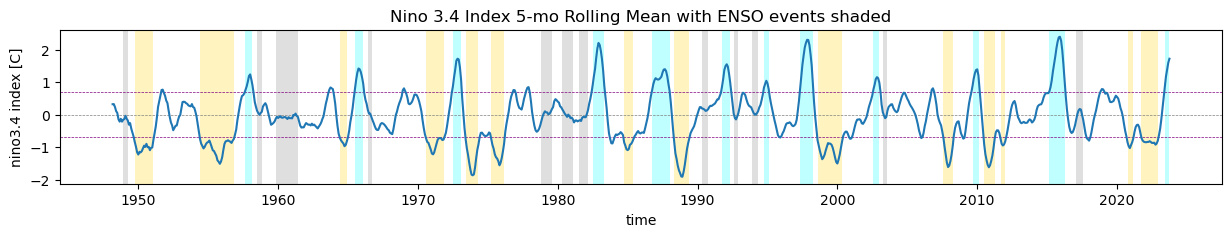

In [161]:
# plot it

fig=plt.figure(figsize=(15,2))

# horizontal guide lines
plt.axhline(y=-event_thresh,color='purple',linestyle='dashed',linewidth=0.5)
plt.axhline(y=0,color='grey',linestyle='dashed',linewidth=0.5)
plt.axhline(y=event_thresh,color='purple',linestyle='dashed',linewidth=0.5)

# plot the rolling mean timeseries with title
nino_rollmean.plot()
plt.title("Nino 3.4 Index 5-mo Rolling Mean with ENSO events shaded")

# add blue shading during nino events
for ievent in range(len(nino_bounds)):
    plt.axvspan(nino_bounds[ievent][0],nino_bounds[ievent][1], color='cyan', alpha=0.25, lw=0)

# add yellow shading during nina events    
for ievent in range(len(nina_bounds)):
    plt.axvspan(nina_bounds[ievent][0],nina_bounds[ievent][1], color='gold', alpha=0.25, lw=0)

# add grey shading during neutral periods    
for ievent in range(len(neutral_bounds)):
    plt.axvspan(neutral_bounds[ievent][0],neutral_bounds[ievent][1], color='grey', alpha=0.25, lw=0)

plt.show()

## 2) Using composite analysis, what pattern do we see in sea surface temperature during El Nino and La Nina?

remember, our array of sea surface temperature anomalies is called **sst_anom**

and we've identified periods with el nino, la nina, or neutral conditions in the array called **nino_events**

A composite is just the time-mean of a group of sst anomaly maps for different months. In this case we'll have one group of sst anomalies for months with el nino conditions and another group of sst anomalies for months with la nina conditions. 

We'll also check what a composite of sst anomalies during neutral conditions looks like. We shouldn't see the strong spatial patterns during neutral conditions that we see during el nino or la nina conditions.

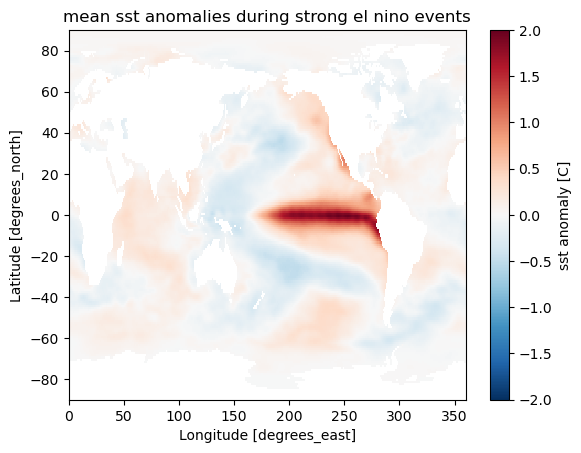

In [162]:
# first make the el nino composite

# keep sst anomalies only for months during el nino events
# then take the average in time
sst_nino=sst_anom.where(nino_events==1).mean('time',keep_attrs=True)

# plot it
sst_nino.plot(vmin=-2.,vmax=2.,cmap='RdBu_r')
plt.title('mean sst anomalies during strong el nino events')
plt.show()

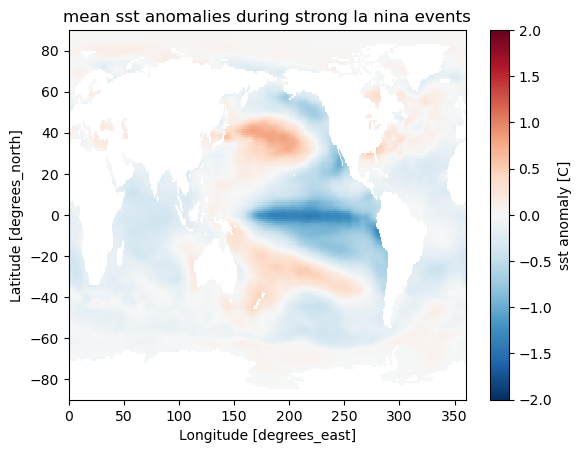

In [163]:
# now make the la nina composite

# keep sst anomalies only for months during la nina events
# then take the average in time
sst_nina=sst_anom.where(nino_events==-1).mean('time',keep_attrs=True)

# plot it
sst_nina.plot(vmin=-2.,vmax=2.,cmap='RdBu_r')
plt.title('mean sst anomalies during strong la nina events')
plt.show()

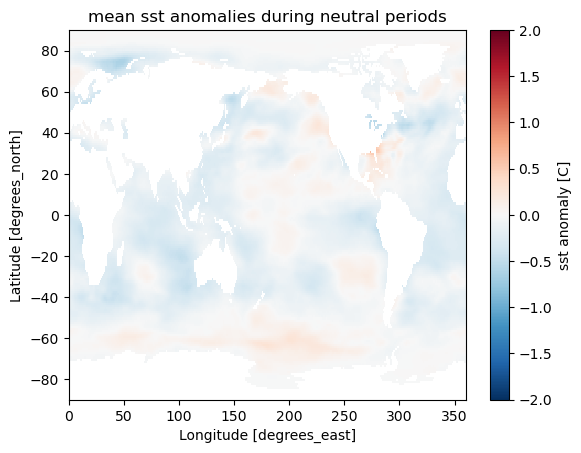

In [164]:
# and now a composite for neutral conditions

# keep sst anomalies only for months during neutral conditions
# then take the average in time
sst_neutral=sst_anom.where(nino_events==0).mean('time',keep_attrs=True)

# plot it
sst_neutral.plot(vmin=-2.,vmax=2.,cmap='RdBu_r')
plt.title('mean sst anomalies during neutral periods')
plt.show()

## 3) In which season(s) does ENSO have the strongest impacts on temperature and precipitation in the US?

# 4) Which areas of the United States experience statistically significant ENSO impacts on temperature and precipitation?

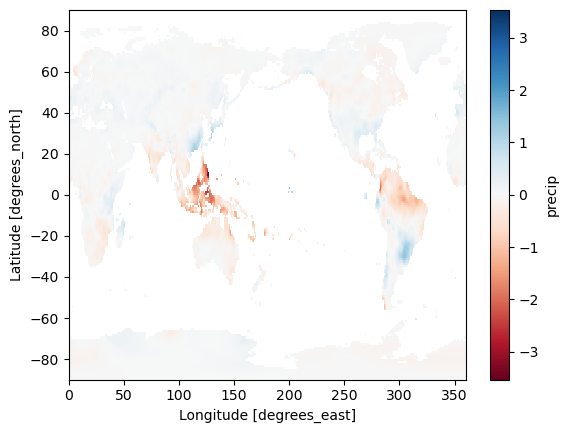

In [165]:
pr_nino=pr_anom.where(nino_events==1).mean('time')
pr_nino.plot(cmap='RdBu')

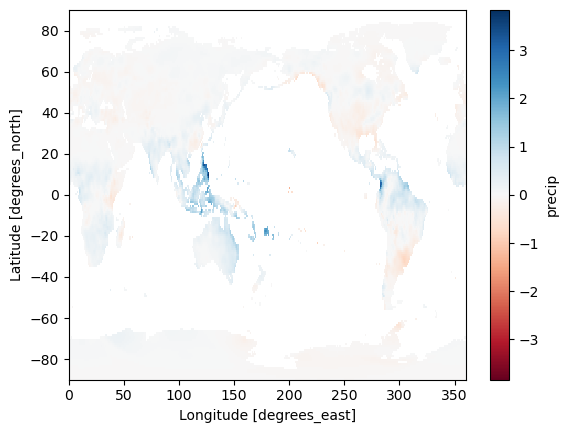

In [166]:
pr_nina=pr_anom.where(nino_events==-1).mean('time')
pr_nina.plot(cmap='RdBu')

In [167]:
# pr_neutral=pr_anom.where(nino_events==0).mean('time')
# pr_neutral.plot(vmin=-3.5,vmax=3.5,cmap='RdBu')

In [168]:
pr_nino

<xarray.DataArray 'precip' (lat: 180, lon: 360)> Size: 259kB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.01687778, -0.01627743, -0.01621715, ..., -0.01794626,
        -0.01742698, -0.01725786],
       [-0.00700885, -0.00678087, -0.00671581, ..., -0.00750605,
        -0.00737321, -0.00721084],
       [-0.0034479 , -0.00345922, -0.00334151, ..., -0.00347738,
        -0.00340593, -0.00346222]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

In [169]:
import cartopy.crs as ccrs
# from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf

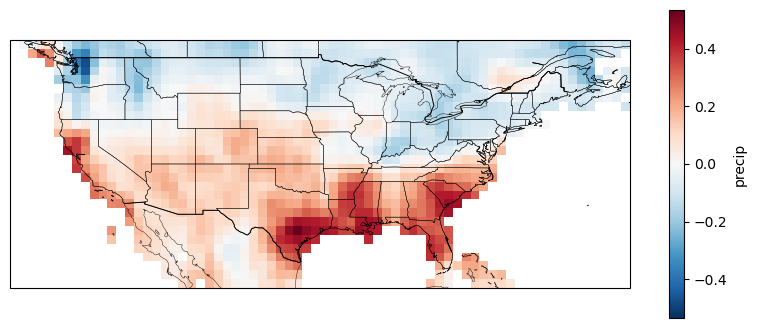

In [170]:
pr_nino_conus=pr_nino.sel(lat=slice(51,23),lon=slice(230,300))

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
cbar_kwargs={'shrink':0.5}
pr_nino_conus.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs=cbar_kwargs)



In [171]:
pr_anom_conus=pr_anom.sel(lat=slice(51,23),lon=slice(225,300))


In [172]:
pr_nino_subset=pr_anom_conus.where(nino_events==1,drop=True)
for season,data in pr_nino_subset.groupby(pr_nino_subset.time.dt.season):
    print(season,data.shape)

DJF (34, 28, 75)
JJA (19, 28, 75)
MAM (19, 28, 75)
SON (35, 28, 75)


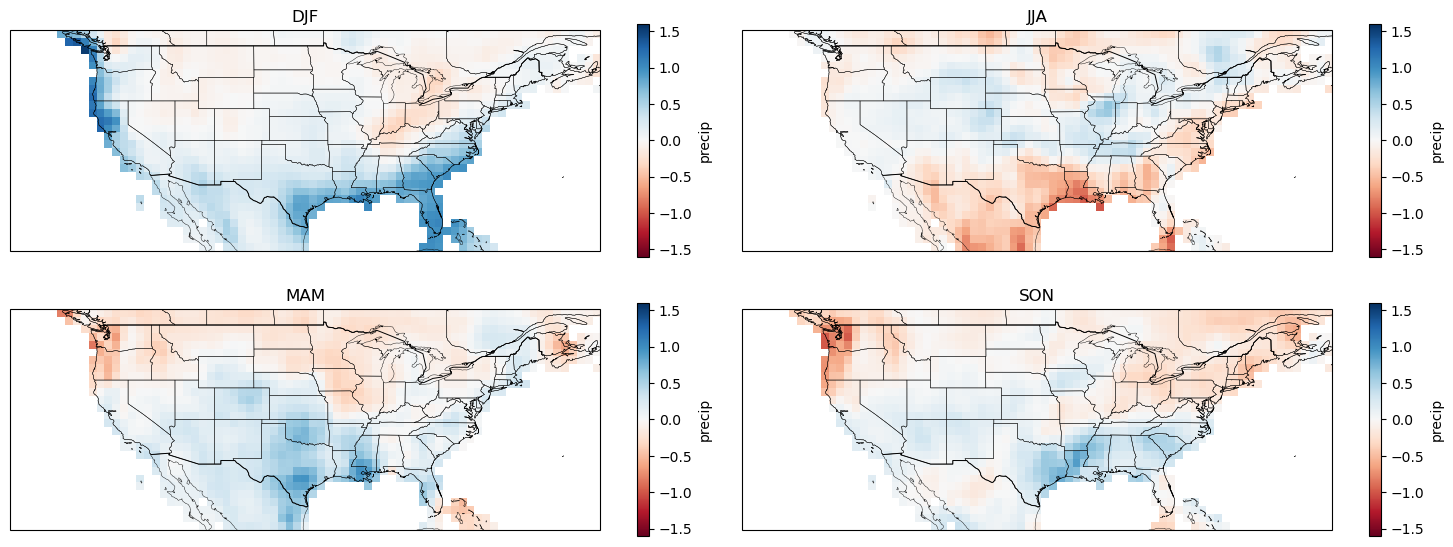

In [184]:
fig=plt.figure(figsize=(15,6))

for i,(season,data) in enumerate(pr_nino_subset.groupby(pr_nino_subset.time.dt.season)):
    season_composite=data.mean('time')

    # fig.add_subplot(2,2,i+1)
    ax=fig.add_subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
    ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
    ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
    cbar_kwargs={'shrink':0.8}
    season_composite.plot(vmin=-1.6,vmax=1.6,cmap='RdBu',cbar_kwargs=cbar_kwargs)#vmin=-7.5,vmax=7.5,cmap='RdBu')
    plt.title(season)

plt.tight_layout()
plt.show()


In [174]:
pr_nina_subset=pr_anom_conus.where(nino_events==-1,drop=True)
for season,data in pr_nina_subset.groupby(pr_nina_subset.time.dt.season):
    print(season,data.shape)

DJF (49, 28, 75)
JJA (40, 28, 75)
MAM (39, 28, 75)
SON (56, 28, 75)


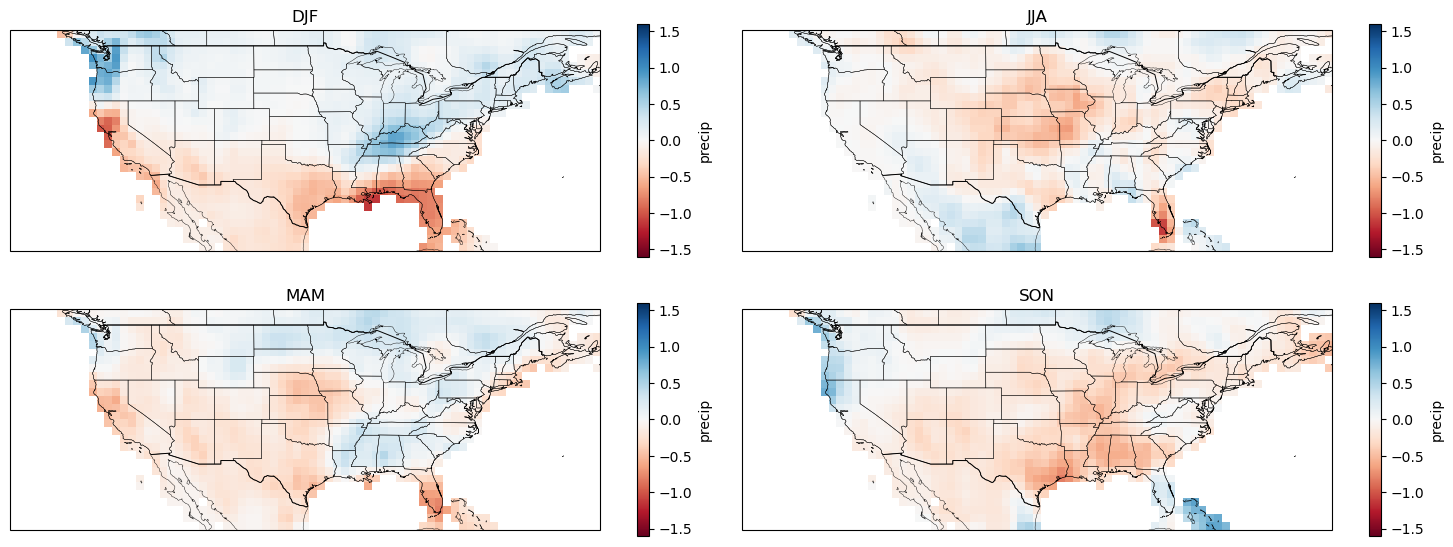

In [186]:
fig=plt.figure(figsize=(15,6))

for i,(season,data) in enumerate(pr_nina_subset.groupby(pr_nina_subset.time.dt.season)):
    season_composite=data.mean('time')

    ax=fig.add_subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
    ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
    ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
    cbar_kwargs={'shrink':0.8}
    season_composite.plot(vmin=-1.6,vmax=1.6,cmap='RdBu',cbar_kwargs=cbar_kwargs)#vmin=-7.5,vmax=7.5,cmap='RdBu')
    plt.title(season)

plt.tight_layout()
plt.show()

In [176]:
pr_neutral_subset=pr_anom_conus.where(nino_events==0,drop=True)
for season,data in pr_neutral_subset.groupby(pr_neutral_subset.time.dt.season):
    print(season,data.shape)

DJF (23, 28, 75)
JJA (27, 28, 75)
MAM (22, 28, 75)
SON (21, 28, 75)


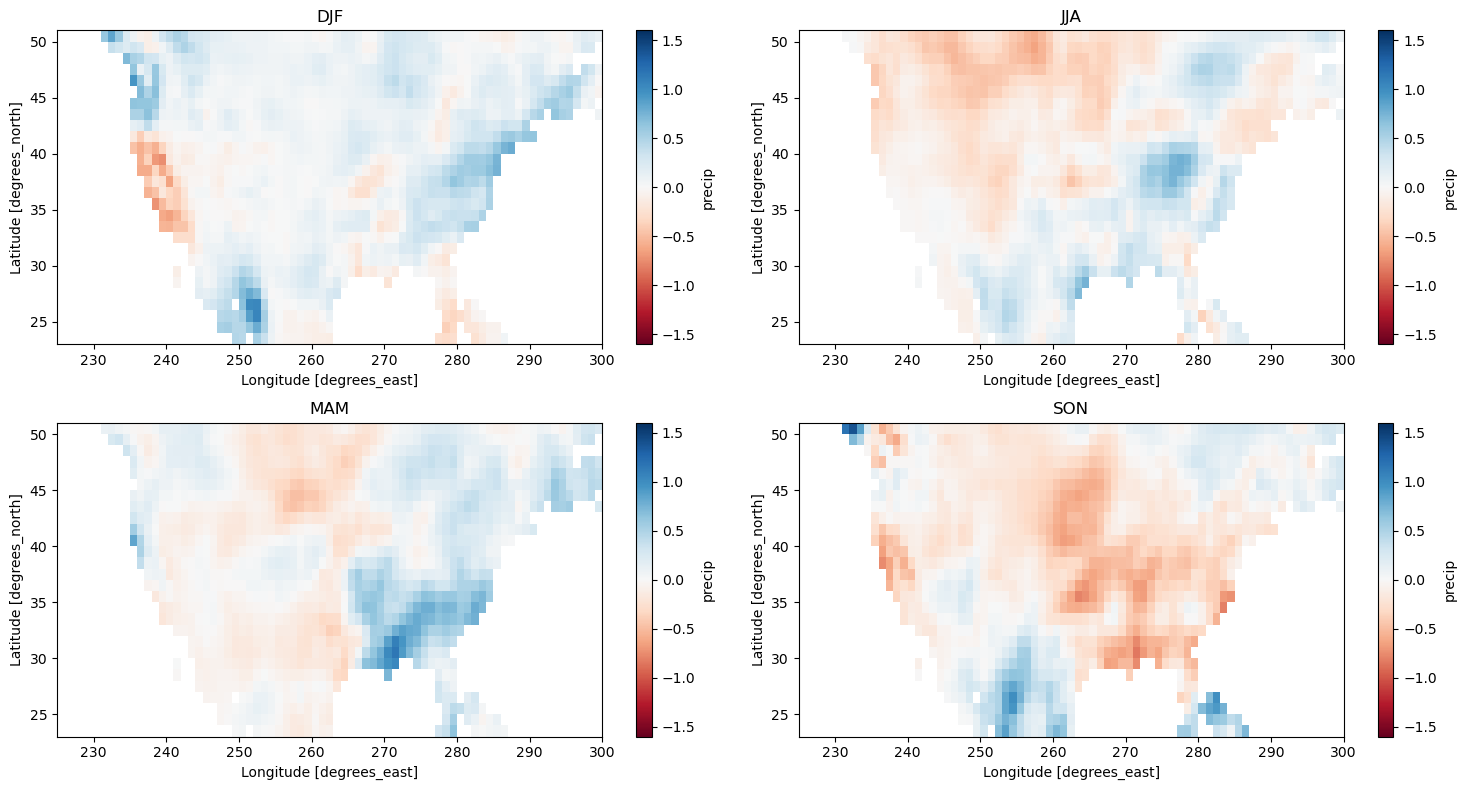

In [180]:
fig=plt.figure(figsize=(15,8))

for i,(season,data) in enumerate(pr_neutral_subset.groupby(pr_neutral_subset.time.dt.season)):
    season_composite=data.mean('time')

    fig.add_subplot(2,2,i+1)
    season_composite.plot(vmin=-1.6,vmax=1.6,cmap='RdBu')#vmin=-7.5,vmax=7.5,cmap='RdBu')
    plt.title(season)

plt.tight_layout()
plt.show()

In [ ]:
# compare event seasons to neutral seasons as well as ltm clim to find significance, t test difference in means
# look for the NOAA season enso anomaly maps 

In [95]:
test=pr_anom.where(nino_events==1).groupby(nino_events.time.dt.season)#.mean('time')

In [101]:
for label,group in test:
    print(label, group.shape)

DJF (228, 180, 360)
JJA (228, 180, 360)
MAM (228, 180, 360)
SON (228, 180, 360)


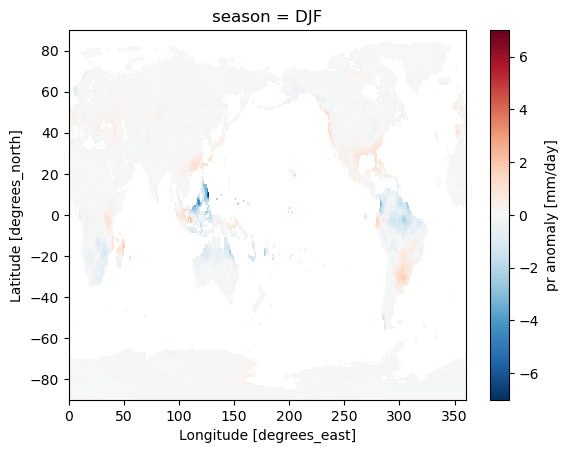

In [92]:
test.sel(season='DJF').plot()

# Your Turn!

### Choose one of three coding mini-projects below to complete on your own and prepare to share your findings


**Option 1 (easiest):** 

&emsp;Hints:
- 

<br>
<br>

**Option 2 (moderate):** 

&emsp;Hints:
- 

<br>
<br>


**Option 3 (hardest):**

&emsp;Hints:
- 



In [ ]:
# peek at the answer figure for option 1

In [ ]:
# peek at the answer figure for option 2

In [ ]:
# peek at the answer figure for option 3

Don't forget to create answer codes for these and put them in the repo. Direct learners to answers after the work-on-your-own session.